In [13]:
import copy

import torch
from basic_transformer import QuantileTransformer, QuantileConvDecoderOnlyTransformer
import attention as ATTN

import numpy as np
import matplotlib.pyplot as plt
from synthetic_datasets import SineSyntheticDataset

(torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

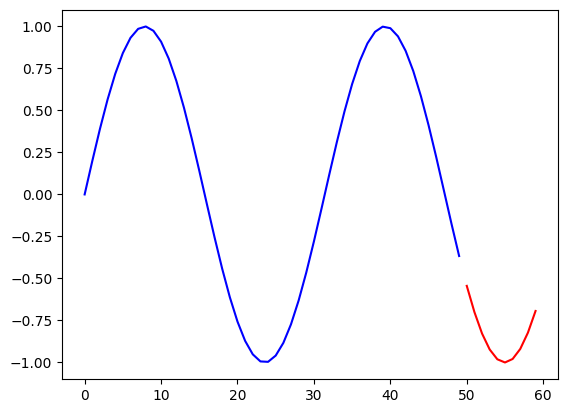

In [178]:
dataset = SineSyntheticDataset(
    len_timeseries=5000,
    seq_len=50,
    shift=10,
    alpha=0.2
)

src_x, src_y, tgt_x, tgt_y = dataset[0]

plt.plot(src_x.numpy(), src_y.numpy(), 'b')
plt.plot(tgt_x.numpy(), tgt_y.numpy(), 'r')

src_x.shape, src_y.shape, tgt_x.shape, tgt_y.shape

In [179]:
from torch.utils.data import DataLoader

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, drop_last=True)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(3952, 494, 494, 123, 7, 7)

In [180]:
def train_step(model, criterion, train_dataloader, optimizer, mask, device):
    model.train()
    train_loss = torch.zeros_like(criterion.q)
    n = 0
    mask = mask.to(device)
    for sample in train_dataloader:
        src_X, src_fX, tgt_X, tgt_fX = (v.to(device) for v in sample)
        
        out = model(src_X, src_fX, mask)
        p_loss = criterion(out[:, -tgt_X.shape[1]:], tgt_fX)

        optimizer.zero_grad()
        p_loss.sum().backward()
        optimizer.step()
        
        train_loss += p_loss * src_X.shape[0]
        n += src_X.shape[0]

    return train_loss / n

def val_step(model, criterion, val_dataloader, mask, device):
    model.eval()
    val_loss = torch.zeros_like(criterion.q)
    n = 0
    mask = mask.to(device)
    with torch.no_grad():
        for sample in val_dataloader:
            src_X, src_fX, tgt_X, tgt_fX = (v.to(device) for v in sample)
            
            out = model(src_X, src_fX, mask)
            p_loss = criterion(out[:, -tgt_X.shape[1]:], tgt_fX)
            
            val_loss += p_loss * src_X.shape[0]
            n += src_X.shape[0]

    return val_loss / n

In [181]:
def create_model(attention_module, config):
    return QuantileTransformer(
        d_in=2,
        n_quantiles=3,
        emb_size=config.emb_size,
        n_heads=config.n_heads,
        n_hidden=config.n_hidden,
        ffn_n_hidden=config.ffn_n_hidden,
        num_layers=1,
        _attention=attention_module,
        norm_first=True
    )

In [182]:
from criterions import QuantileLoss
import argparse

def format_print(loss: dict):
    return ', '.join([f"{p}:{l:.4f}" for p, l in loss.items()])

def train(attn_module, config, train_dl, val_dl, verbose=False):
    
    model = create_model(attn_module, config).to(config.device)
    
    train_history = []
    val_history = []
    
    criterion = QuantileLoss(config).to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    best_val_loss = float('inf')
    early_stopping_c = 0
    best_model = None
    
    for epoch in range(config.epochs):
    
        train_loss = train_step(model, criterion, train_dl, optimizer, dataset.mask, config.device)
        train_history.append({'p10': train_loss[0].item(), 'p50': train_loss[1].item(), 'p90': train_loss[2].item()})
    
        val_loss = val_step(model, criterion, val_dl, dataset.mask, config.device)
        val_history.append({'p10': val_loss[0].item(), 'p50': val_loss[1].item(), 'p90': val_loss[2].item()})
        
        if verbose: print(f"{epoch=}\t{format_print(train_history[-1])}\t{format_print(val_history[-1])}")
        
        val_loss_sum = val_loss.sum().item()
        scheduler.step(val_loss_sum)
        
        if val_loss_sum < best_val_loss:
            best_val_loss = val_loss_sum
            early_stopping_c = 0
            best_model = copy.deepcopy(model)
        else:
            early_stopping_c += 1
            
        if early_stopping_c > config.patience: break
    
    return best_model, train_history, val_history, best_val_loss

In [200]:
from configuration import get_attention_hparam_grid, make_attn_module_class, get_attention_names

attn_names = get_attention_names()

config = argparse.Namespace()
config.quantiles = [0.1, 0.5, 0.9]
config.lr = 1e-2
config.epochs = 200
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.patience = 10
config.attn_dropout = 0.1

config.emb_size = 20
config.n_heads = 4
config.n_hidden = 32
config.ffn_n_hidden = 10

results = {}

for attn_name in attn_names:
    
    attn_hparam_grid = get_attention_hparam_grid(attn_name)
    attn_module_class = make_attn_module_class(attn_name)
    
    best_model = None
    best_val_loss = float('inf')
    best_attn_hparams = None
    best_train_history, best_val_history = None, None
    
    print(f'Starting training for attention module: {attn_name}')
    
    for attn_hparams in attn_hparam_grid:
        
        attn_hparams['dropout_rate'] = config.attn_dropout
        if attn_name == 'imp':
            attn_hparams['input_size'] = config.n_hidden // config.n_heads
        
        attn_module = attn_module_class(**attn_hparams)
        model, train_history, val_history, val_loss = train(attn_module, config, train_dl, val_dl, verbose=False)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_attn_hparams = attn_hparams
            best_train_history = train_history
            best_val_history = val_history
            
        print(f'\t{attn_hparams=}, {val_loss=:.4f}, {best_val_loss=:.4f}')
    
    criterion = QuantileLoss(config).to(config.device)
    test_loss = val_step(best_model, criterion, test_dl, dataset.mask, config.device).cpu()    
    results[attn_name] = {
        'attn_name': attn_name, 
        'test_loss': test_loss, 
        'best_model': best_model, 
        'best_attn_params': best_attn_hparams,
        'best_train_history': best_train_history, 
        'best_val_history': best_val_history
    }

Starting training for attention module: sdp
	attn_hparams={'dropout_rate': 0.1}, val_loss=0.2526, best_val_loss=0.2526
Starting training for attention module: lin
	attn_hparams={'dropout_rate': 0.1}, val_loss=0.1223, best_val_loss=0.1223
Starting training for attention module: exp
	attn_hparams={'p_norm_sim': 1, 'p_norm_mag': 1, 'include_magnitude': True, 'dropout_rate': 0.1}, val_loss=0.2943, best_val_loss=0.2943
	attn_hparams={'p_norm_sim': 2, 'p_norm_mag': 1, 'include_magnitude': True, 'dropout_rate': 0.1}, val_loss=0.2747, best_val_loss=0.2747
	attn_hparams={'p_norm_sim': 1, 'p_norm_mag': 2, 'include_magnitude': True, 'dropout_rate': 0.1}, val_loss=0.3134, best_val_loss=0.2747
	attn_hparams={'p_norm_sim': 1, 'p_norm_mag': 0, 'include_magnitude': False, 'dropout_rate': 0.1}, val_loss=0.1546, best_val_loss=0.1546
	attn_hparams={'p_norm_sim': 2, 'p_norm_mag': 0, 'include_magnitude': False, 'dropout_rate': 0.1}, val_loss=0.2900, best_val_loss=0.1546
Starting training for attention modu

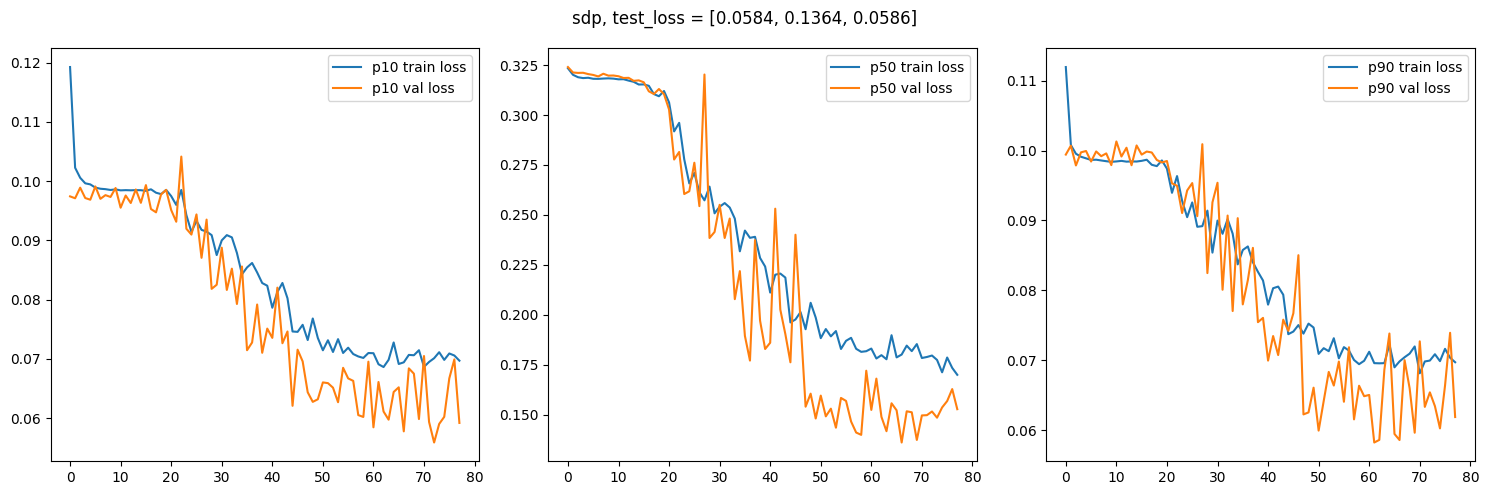

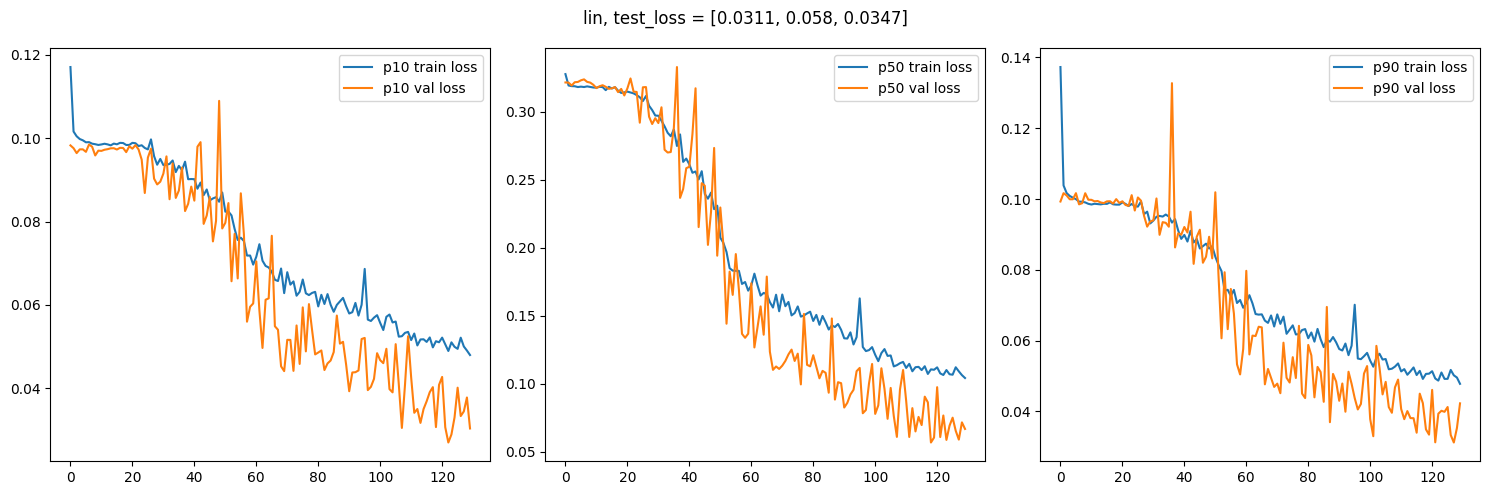

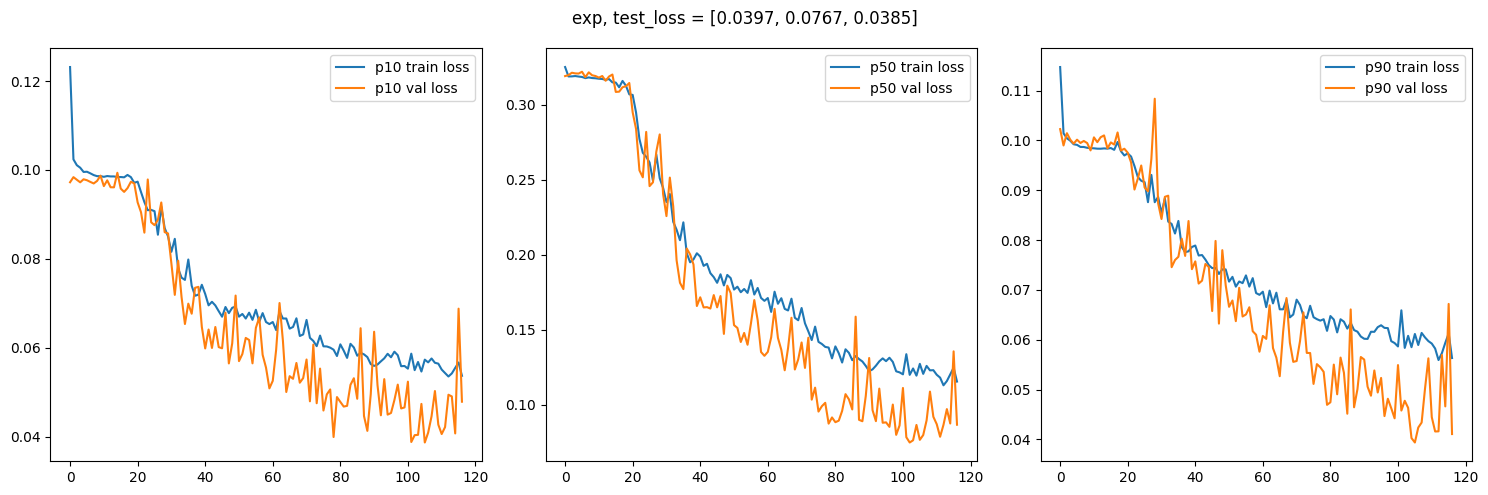

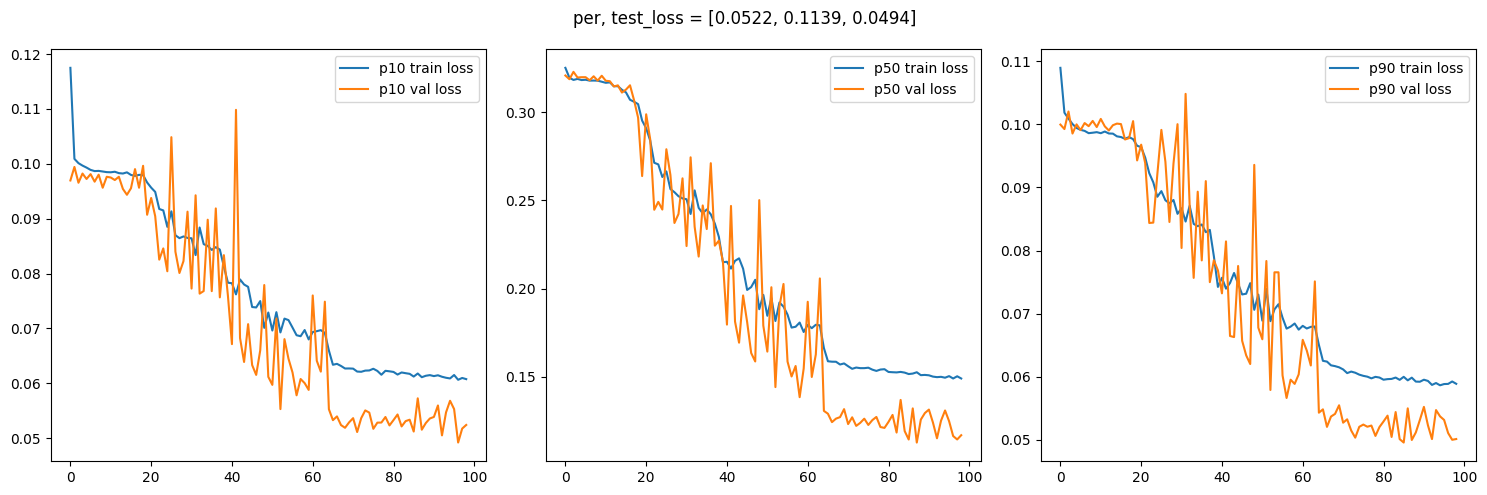

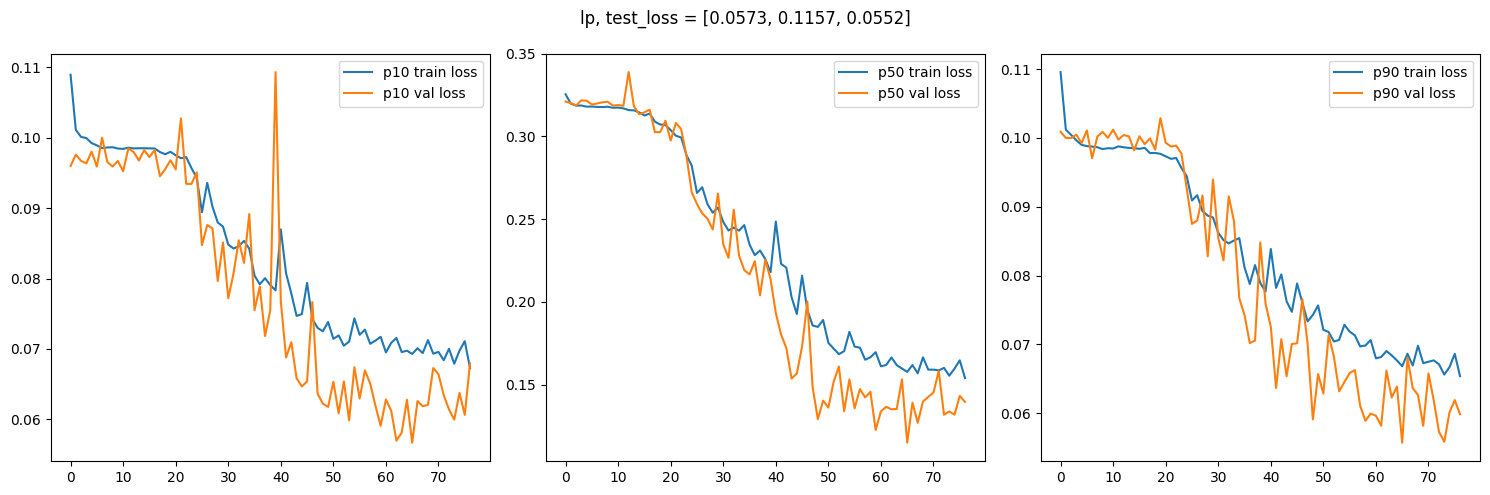

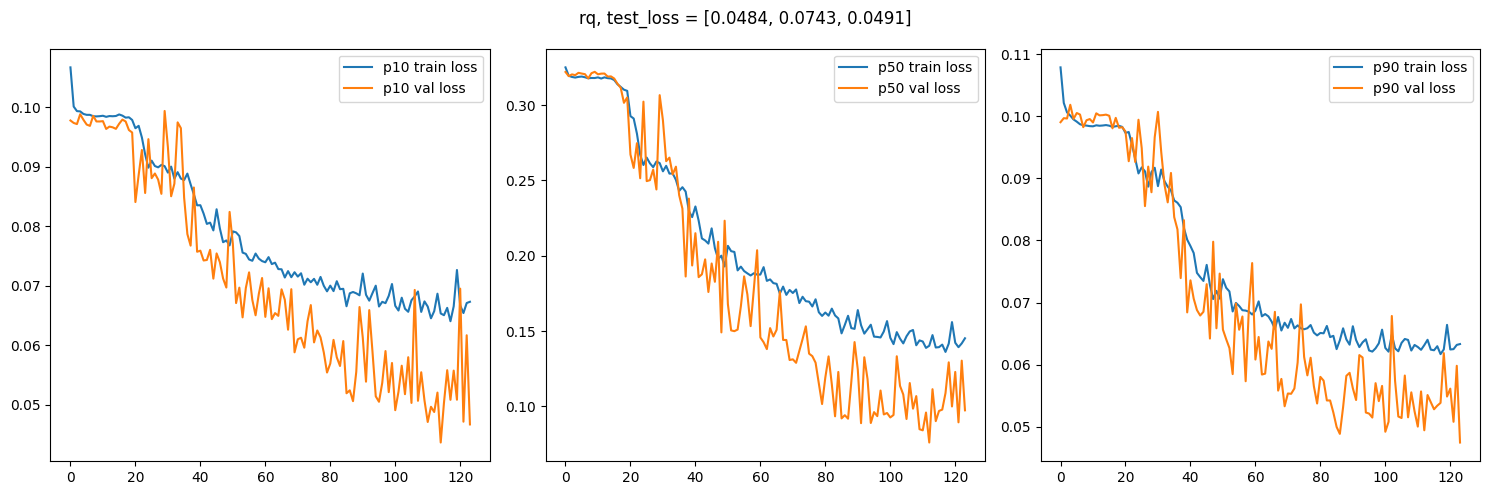

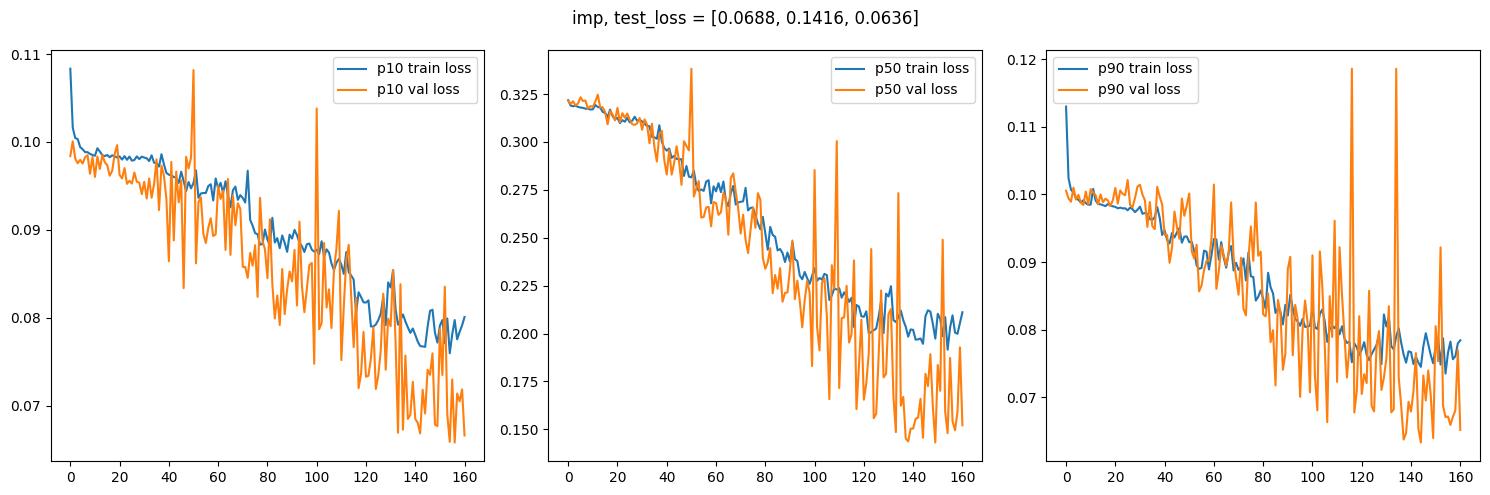

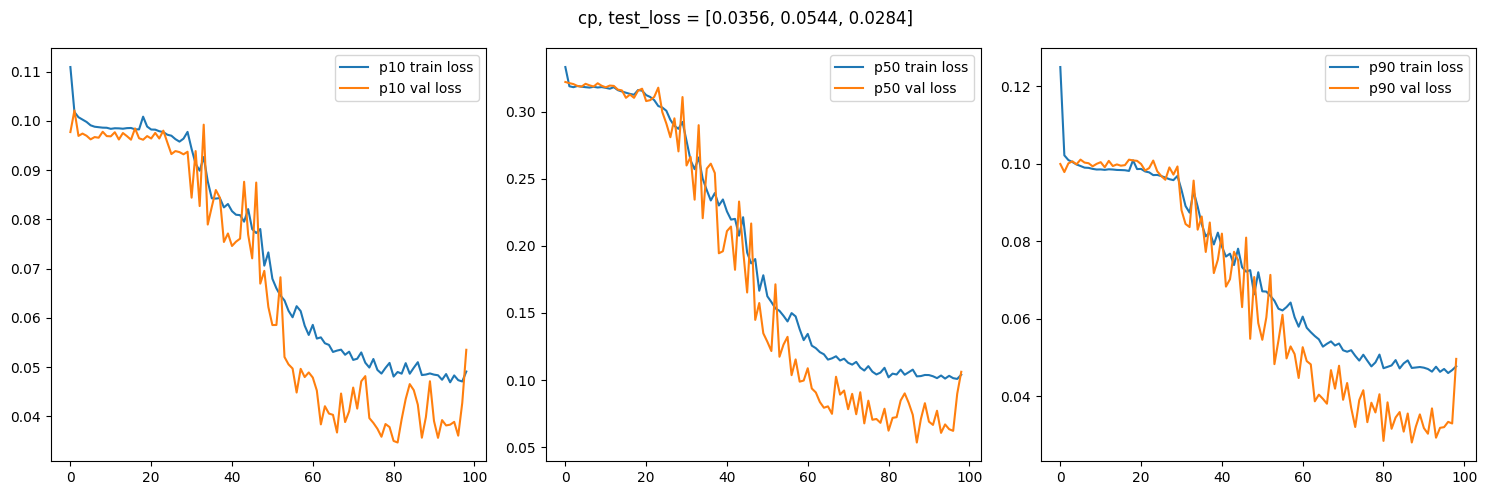

In [201]:
for name, exp in results.items():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
    
    train_history = exp['best_train_history']
    val_history = exp['best_val_history']
    
    p10_train = [x['p10'] for x in train_history]
    p50_train = [x['p50'] for x in train_history]
    p90_train = [x['p90'] for x in train_history]
    
    p10_val = [x['p10'] for x in val_history]
    p50_val = [x['p50'] for x in val_history]
    p90_val = [x['p90'] for x in val_history]
    
    ax1.plot(p10_train, label='p10 train loss')
    ax1.plot(p10_val, label='p10 val loss')
    ax1.legend()
    
    ax2.plot(p50_train, label='p50 train loss')
    ax2.plot(p50_val, label='p50 val loss')
    ax2.legend()
    
    ax3.plot(p90_train, label='p90 train loss')
    ax3.plot(p90_val, label='p90 val loss')
    ax3.legend()
    
    fig.suptitle(f'{exp["attn_name"]}, test_loss = {[round(q, 4) for q in exp["test_loss"].numpy()]}')
    
    plt.tight_layout()
    plt.show()

In [202]:
def inference(idx, best_model, test_set, config, attn_name):
    with torch.no_grad():
        src_X, src_fX, tgt_X, tgt_fX = test_set[idx]
        
        out = best_model(src_X.unsqueeze(0).to(config.device), 
                         src_fX.unsqueeze(0).to(config.device), 
                         dataset.mask.to(config.device))
        
        pred = out[:, -tgt_X.shape[0]:].squeeze().cpu()
        
        num_horizons = tgt_X.shape[0]
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
        ax1.plot(src_X, src_fX, '-r', label="Source: 0: t_0")
        ax1.plot(tgt_X, tgt_fX, '-b', label=f"Target: $t_0+1: t_0+{num_horizons}$")
        ax1.plot(tgt_X, pred[:, 1], '-g', label=f"Prediction: $t_0+1: t_0+{num_horizons}$")
        ax1.fill_between(tgt_X.squeeze(), pred[:, 0], pred[:, 2], alpha=0.2, color='green', label=f"Prediction quantiles: $t_0+1: t_0+{num_horizons}$")
        ax1.axvline(src_X[-1, 0], linestyle='--', color='k')
        ax1.legend()
        
        attn_w = best_model.transformer_blocks[0].mha.attn_weights[0].cpu()
        for j, attn in enumerate(attn_w):
            ax2.plot(src_X, attn[-1], label=f"Attention head {j + 1}")
        ax2.axvline(src_X[-1, 0], linestyle='--', color='k')
        ax2.legend()
    
        ax1.set_title(f"Quantile Prediction for attention module: {attn_name}")
        ax2.set_title(f"Attention weights for horizon: $0: t_0+{num_horizons}$")
        
        plt.tight_layout()
        plt.show()
        
        fig, axes = plt.subplots(1, attn_w.shape[0], figsize=(5*attn_w.shape[0], 5))
        fig.suptitle(f'Attention weight matrix visualization for module: {attn_name}')
        
        for j, (ax, attn) in enumerate(zip(axes, attn_w)):
            t = torch.arange(attn.shape[0]).reshape(-1, 1)
            attn = attn.cpu() * t
            ax.imshow(attn)
            ax.set_title(f'Attention head {j + 1}')
        
        plt.show()

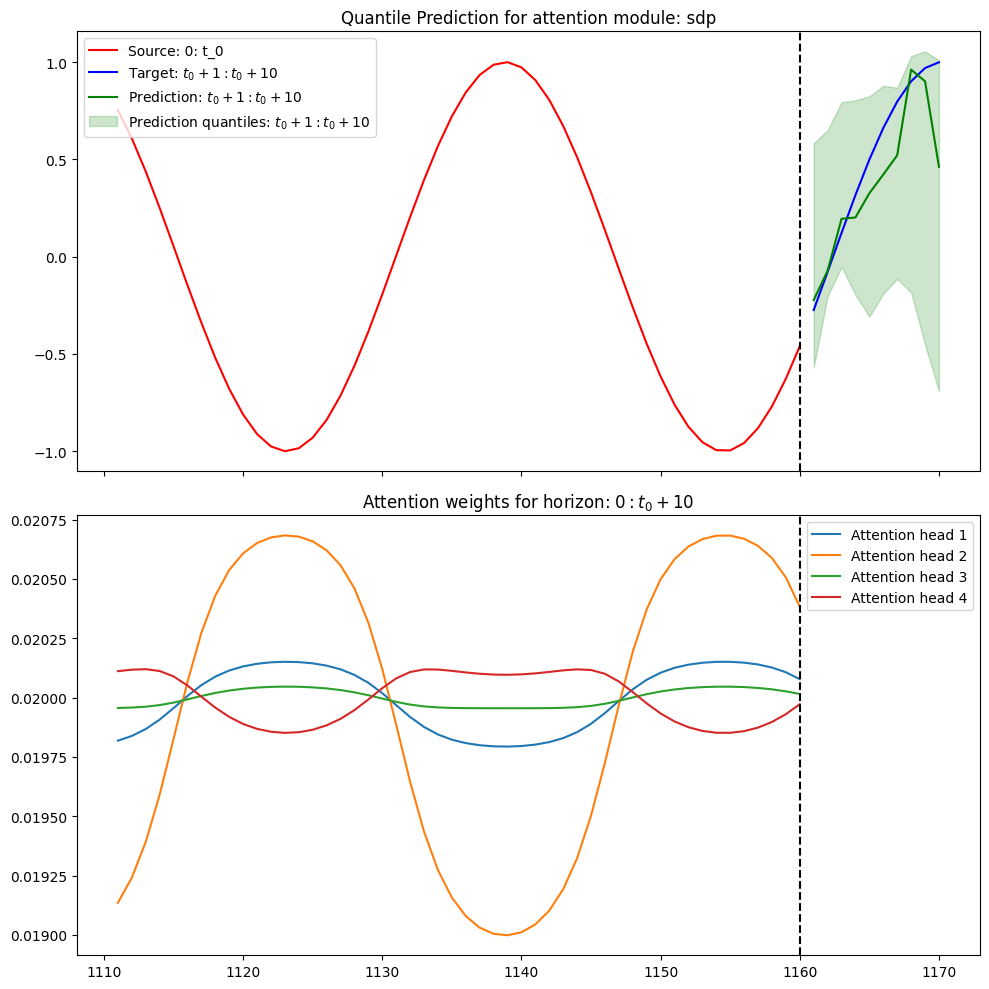

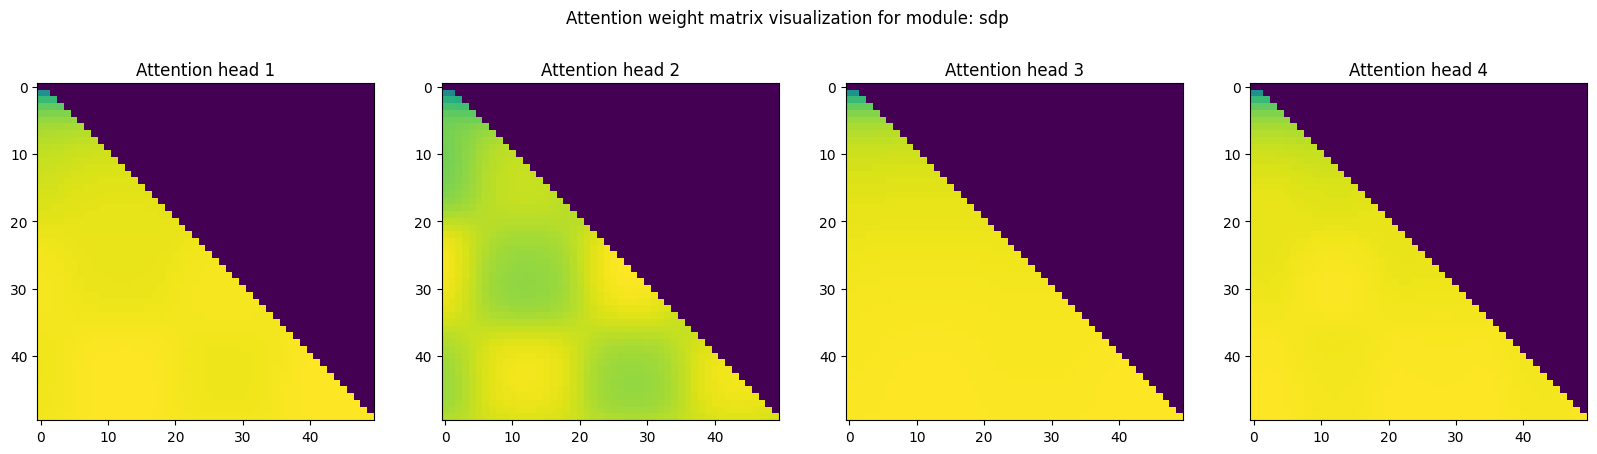

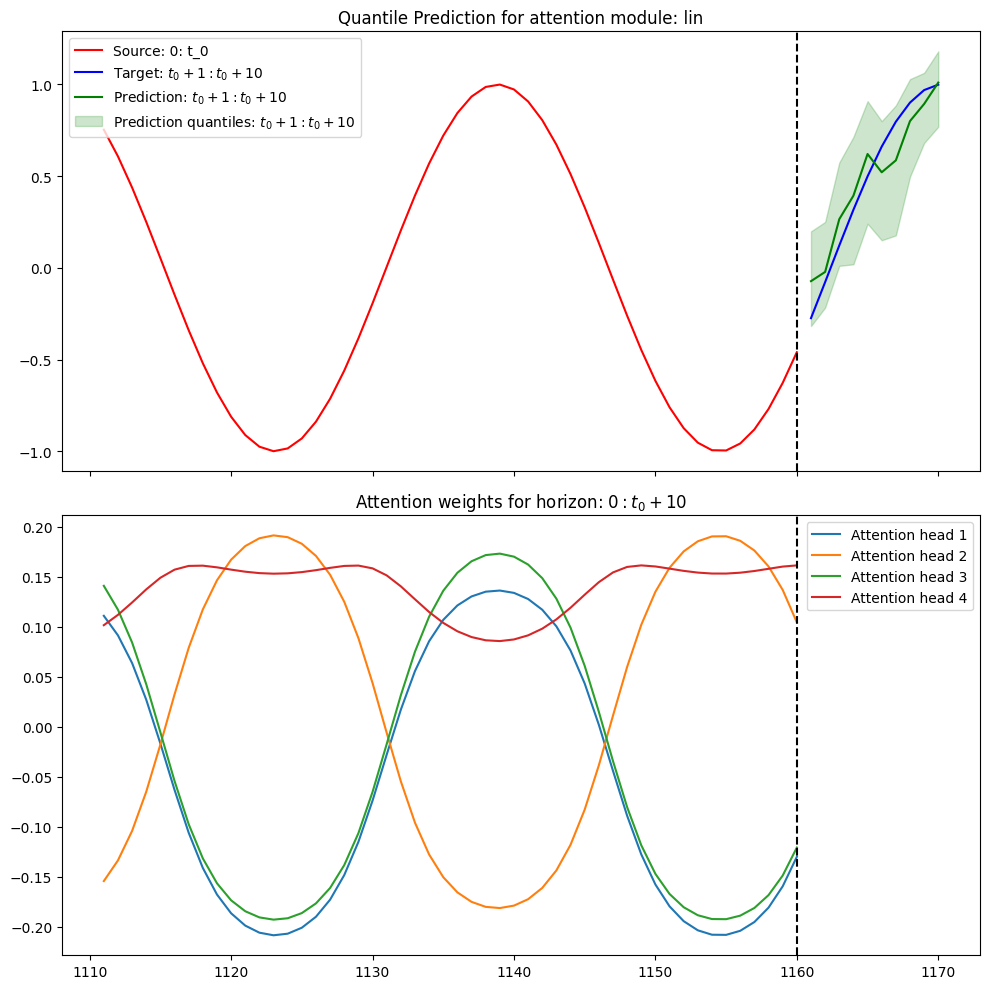

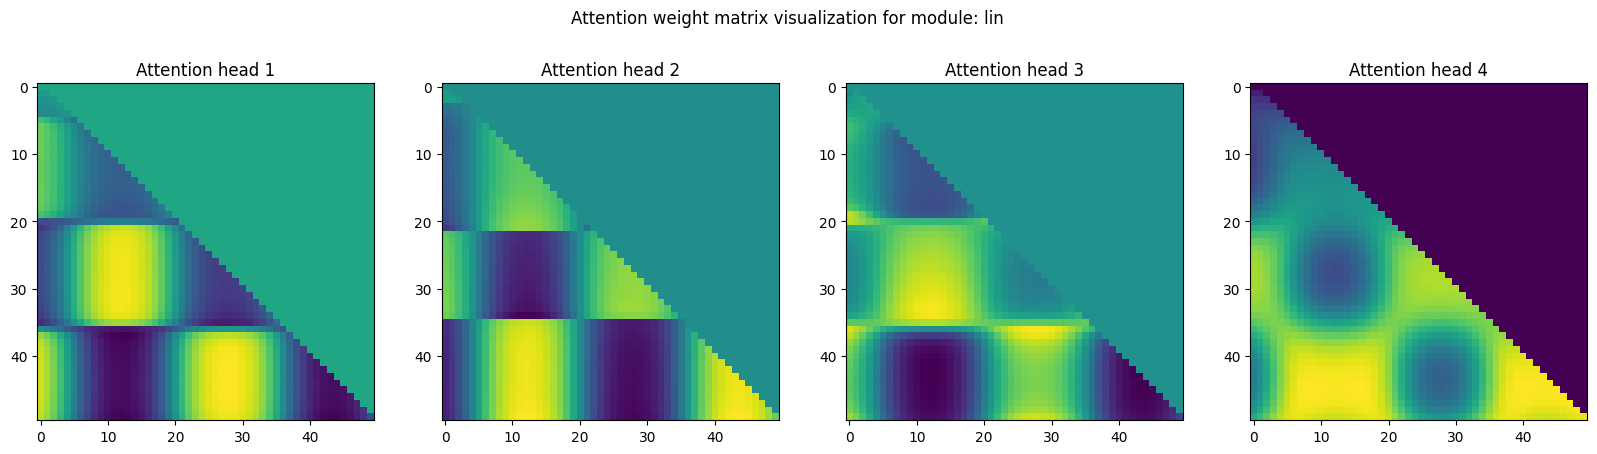

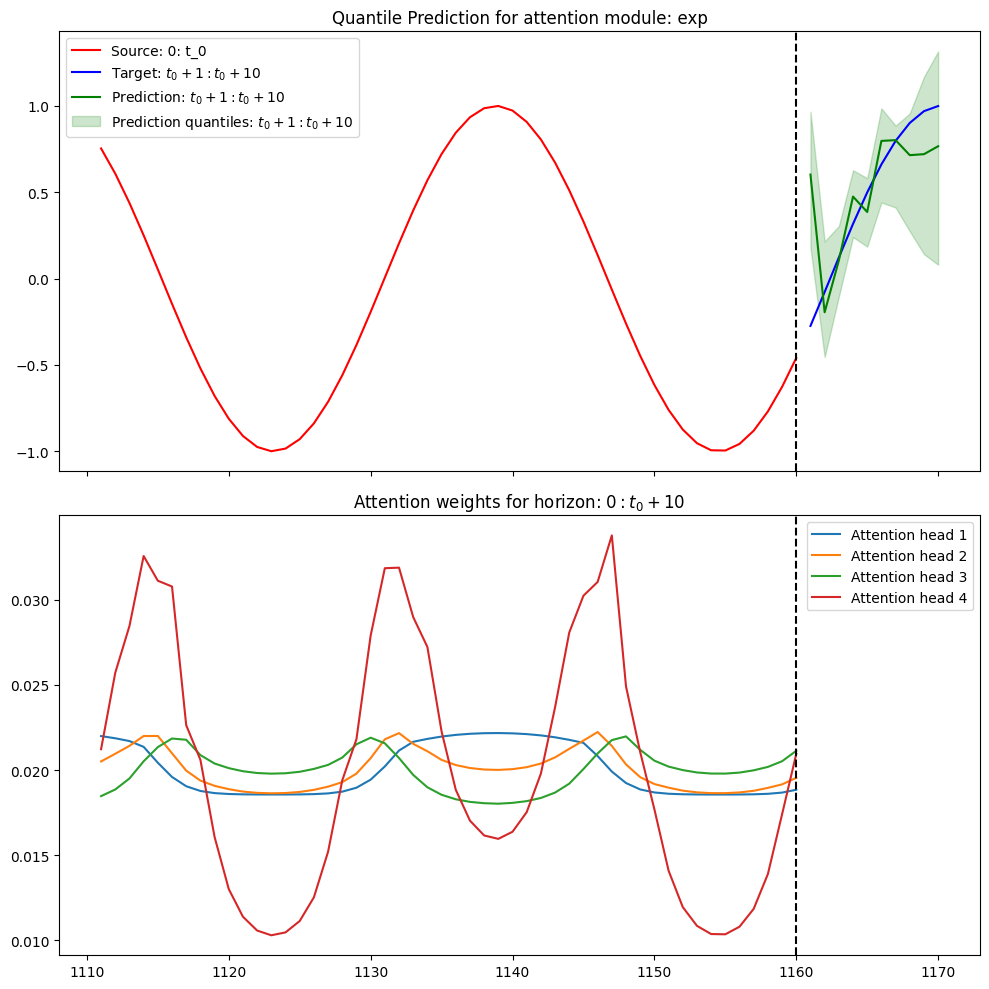

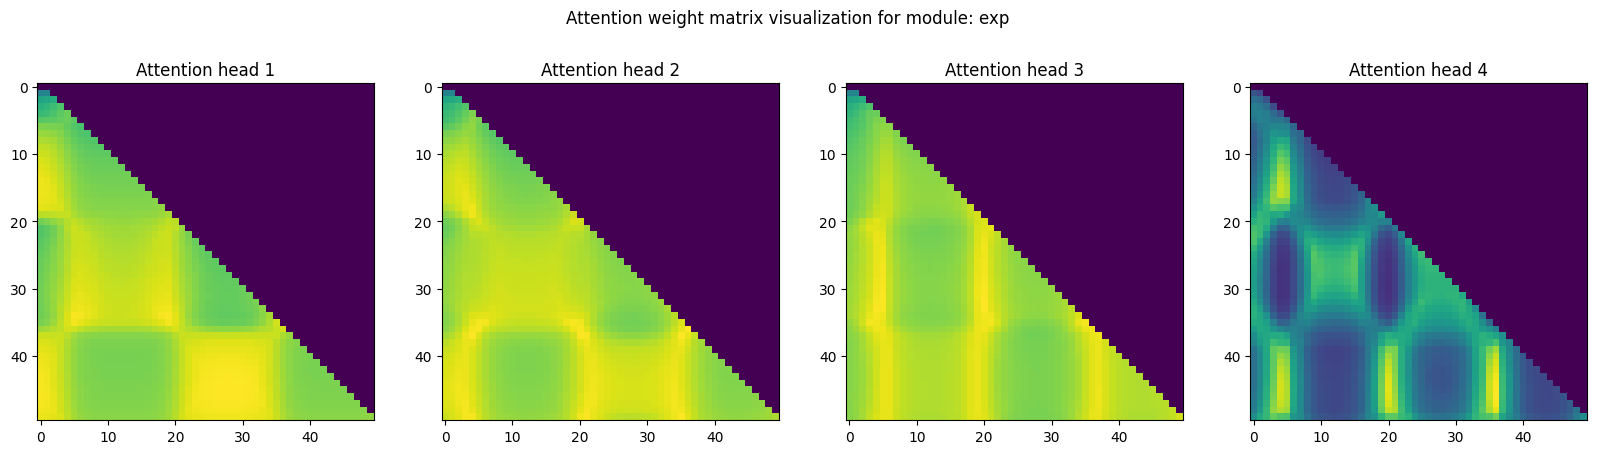

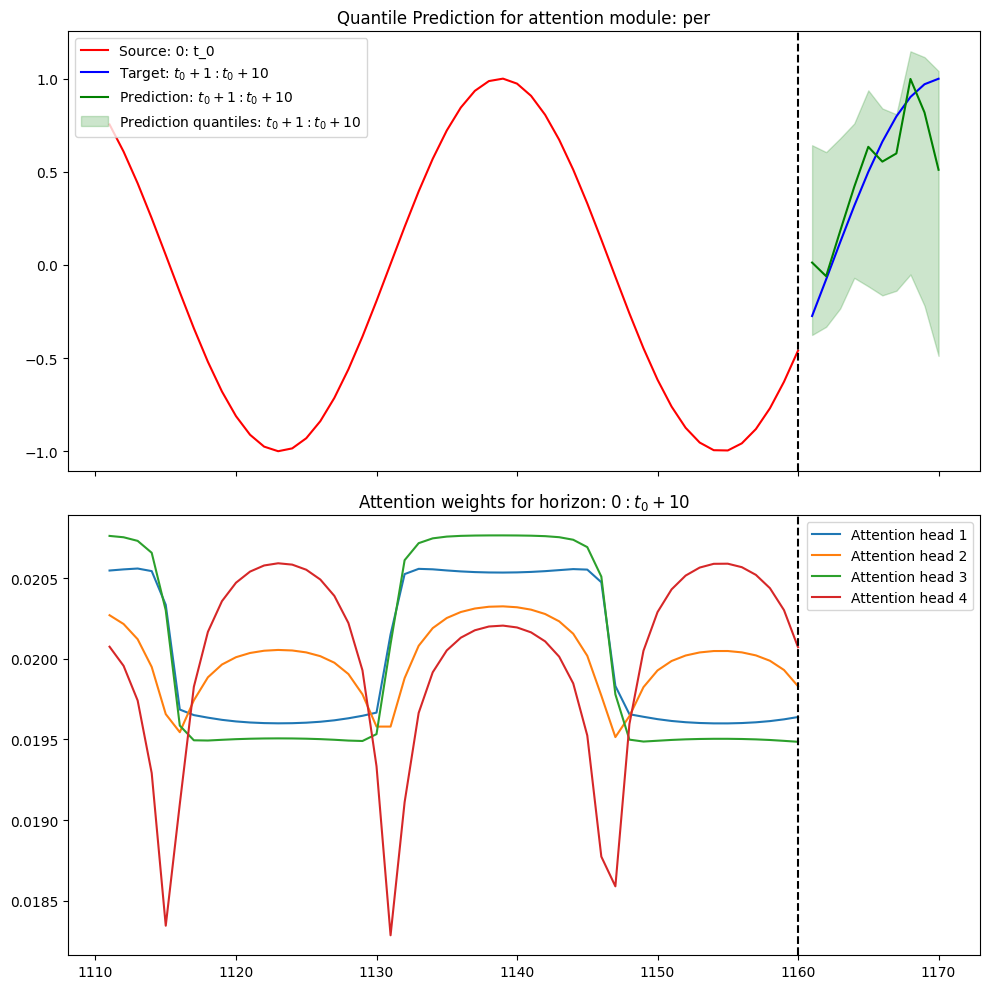

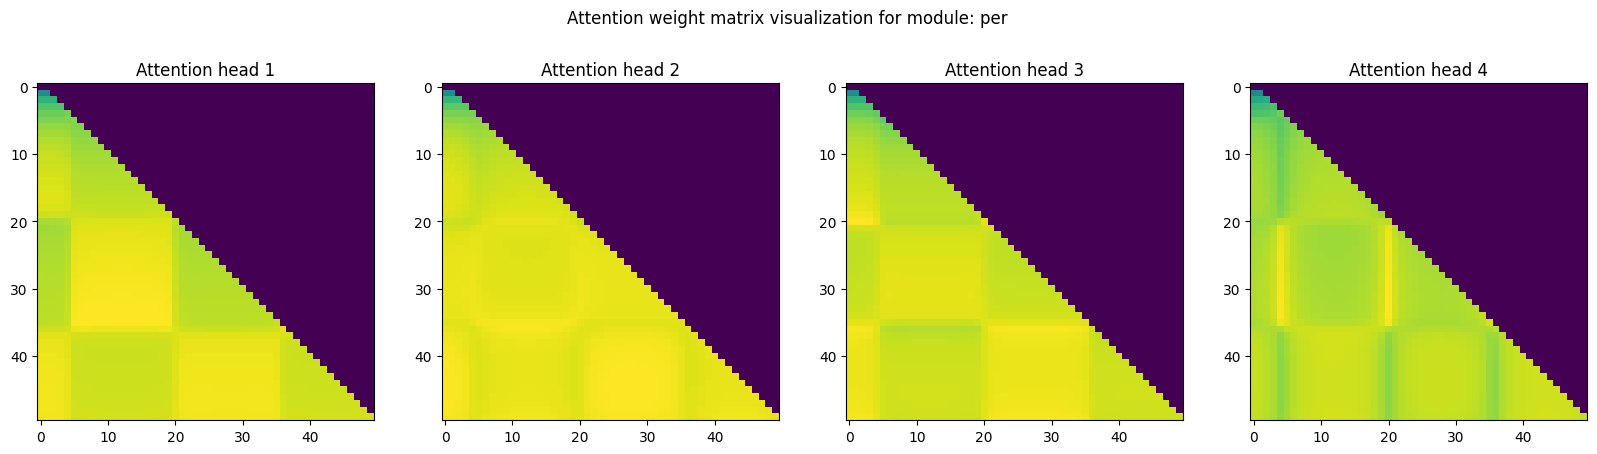

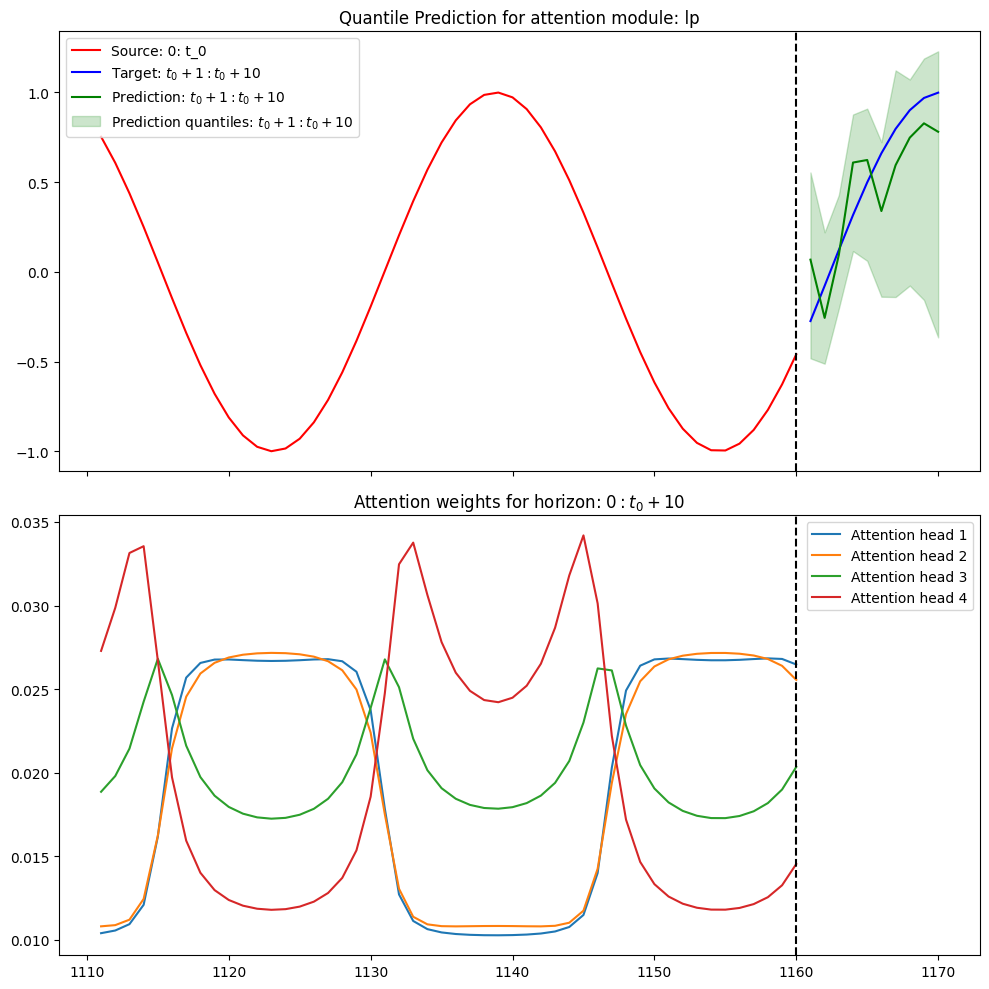

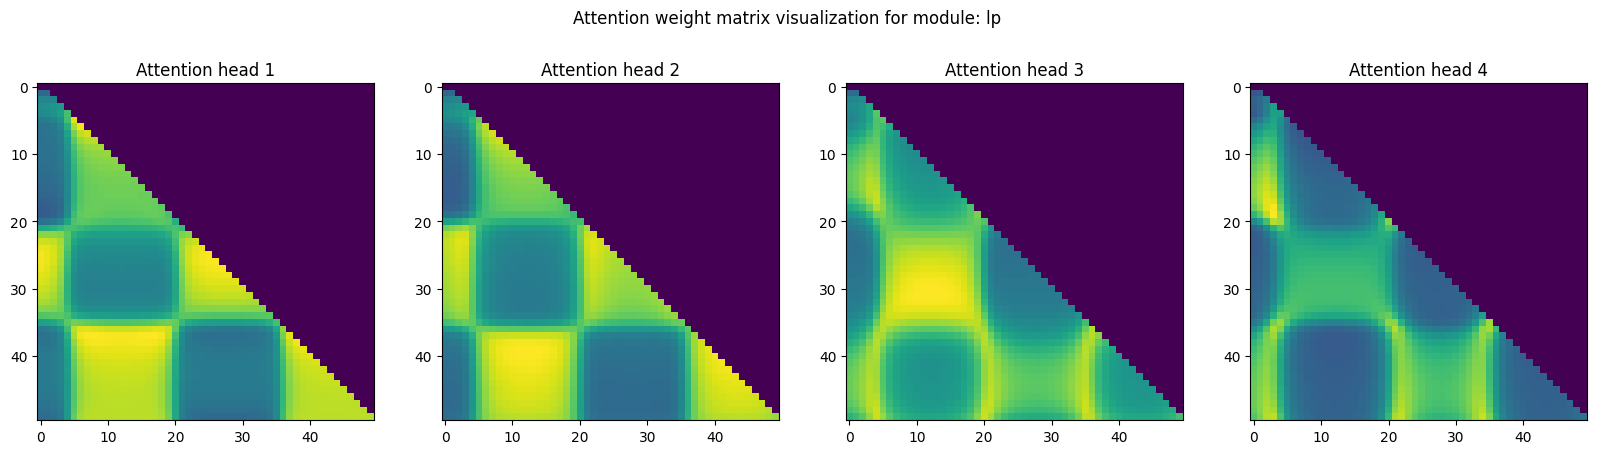

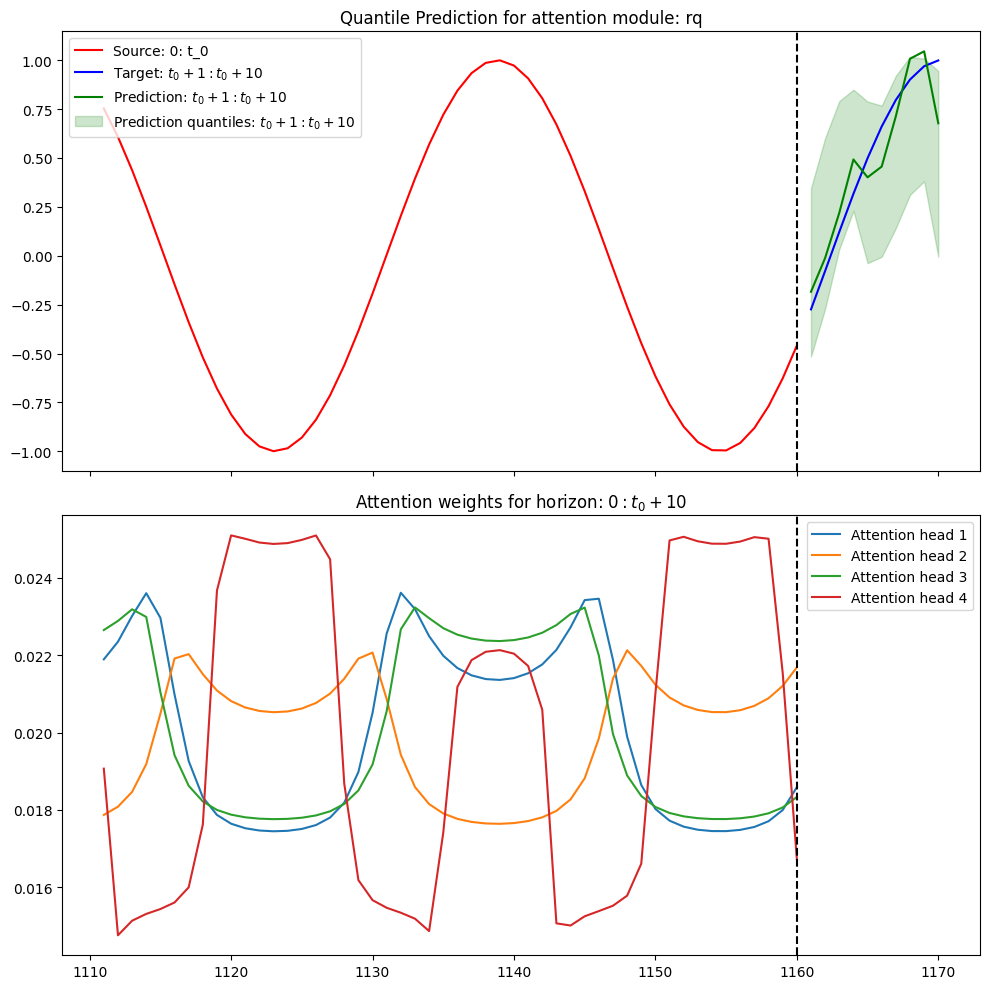

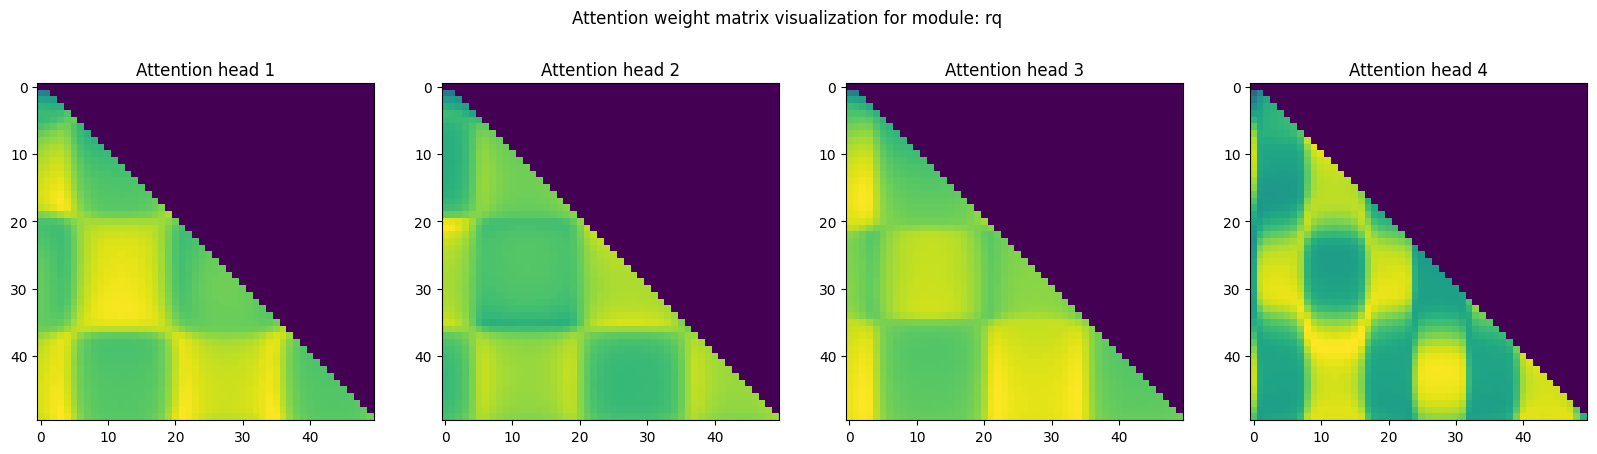

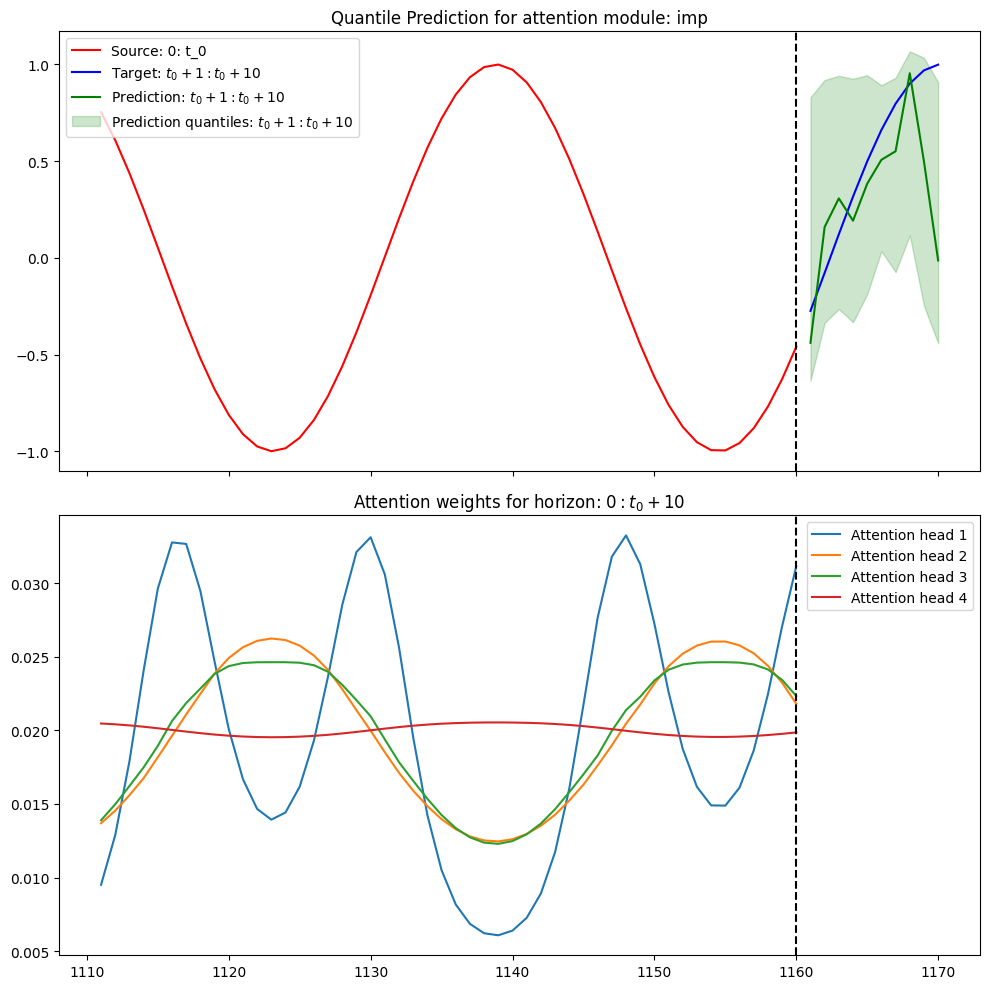

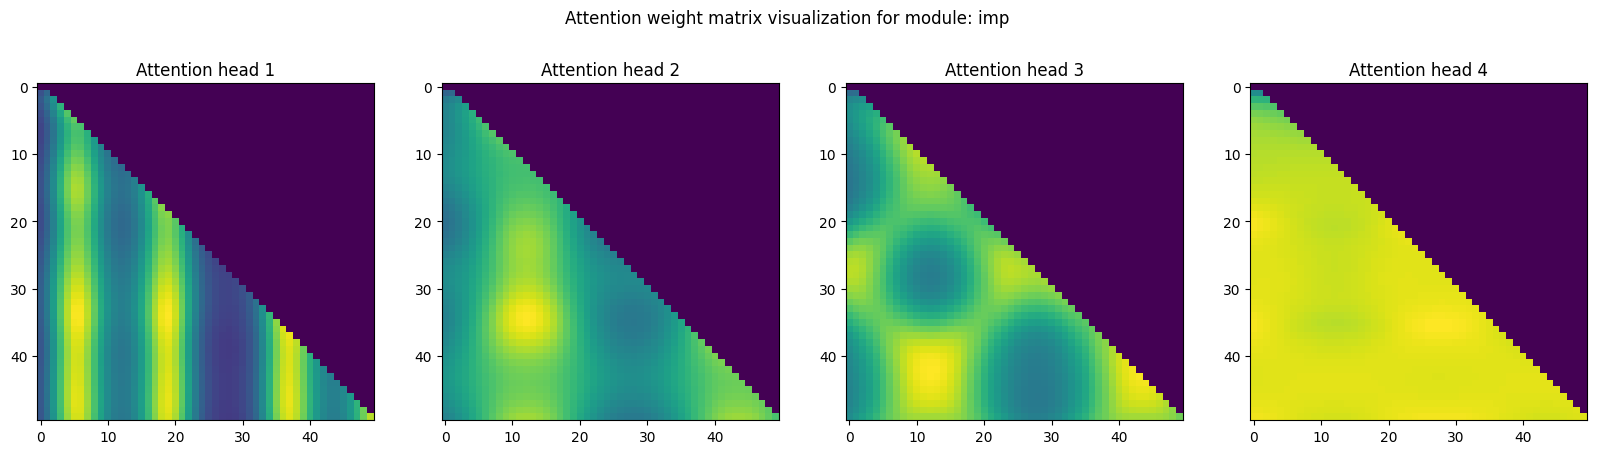

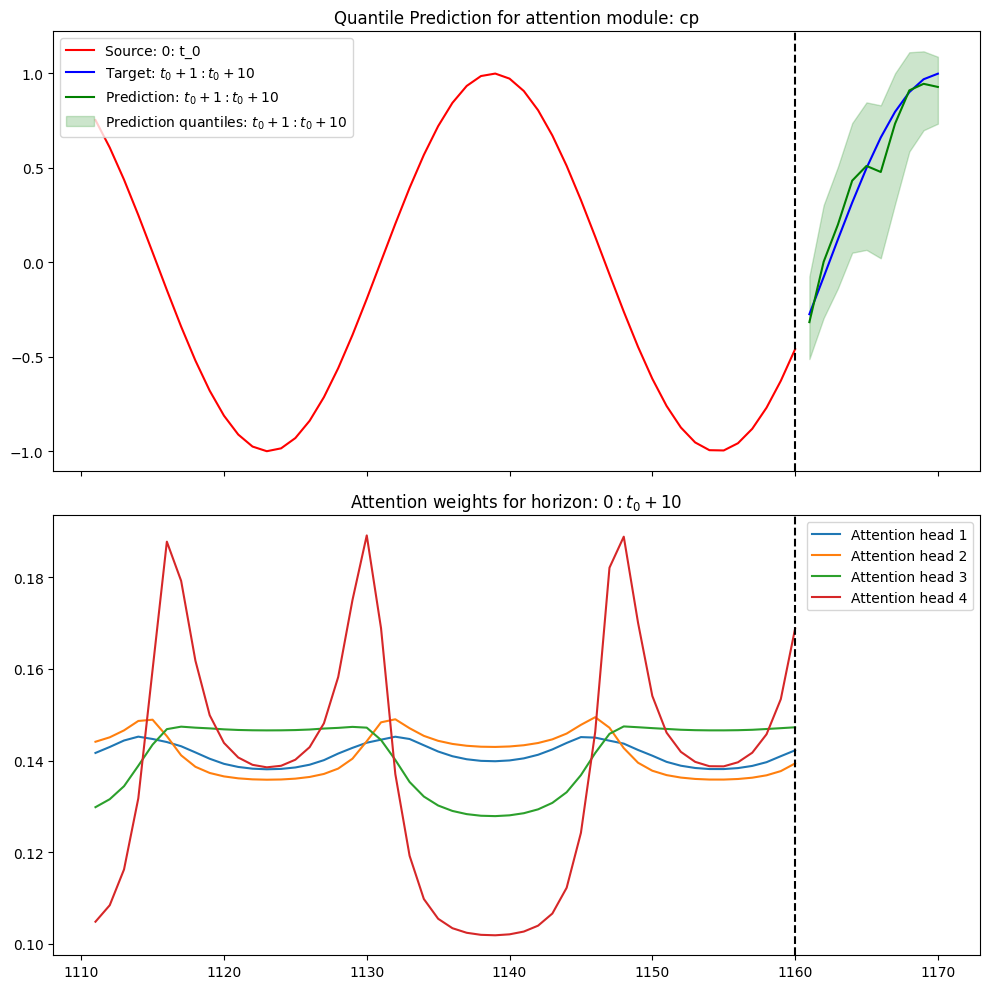

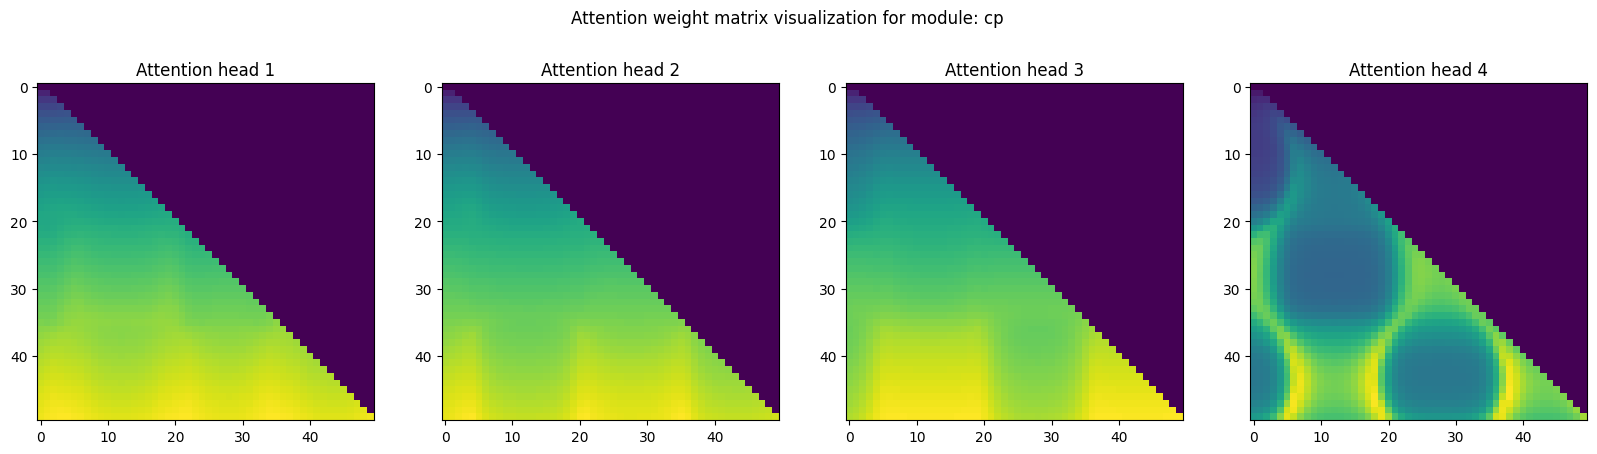

In [203]:
idx = 15

for name, exp in results.items():
    
    best_model = exp['best_model']
    attn_name = exp['attn_name']
    
    inference(idx, best_model, test_set, config, attn_name)

In [204]:
import os

results_path = os.path.join('results_sine_exp')

os.makedirs(results_path, exist_ok=True)

In [206]:
for name, exp in results.items():
    ckpt = {
        'name': name, 
        'config': config, 
        'model': exp['best_model'].state_dict(), 
        'attn_name': exp['attn_name'], 
        'test_loss': exp['test_loss'], 
        'best_model': exp['best_model'], 
        'best_attn_params': exp['best_attn_params']
    }
    
    torch.save(ckpt, os.path.join(results_path, f'{name}_checkpoint.pt'))